In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
import newcmaps

import numpy as np
import healpy as hp
import scipy
from scipy import special as ss
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import math,glob
import NX01_bayesutils as bu
import NX01_utils as utils

# IPTA MDC injection

## Injected map

In [2]:
clm_inj = np.load('nanogravTests_pointAnis.npy')

In [3]:
clm_inj

array([ 3.5449077 , -0.58004952,  0.5000429 ,  0.38757574, -0.58507975,
       -0.75636711,  0.00869584,  0.50537718, -0.24235522, -0.10852881,
       -0.90302081, -0.38019683, -0.49805607,  0.25403584, -0.37405437,
       -0.54562877,  0.33893872, -0.18974301, -0.69957401,  0.28682588,
       -0.58943123, -0.19167782, -0.28981041, -0.95390645, -0.33894172])

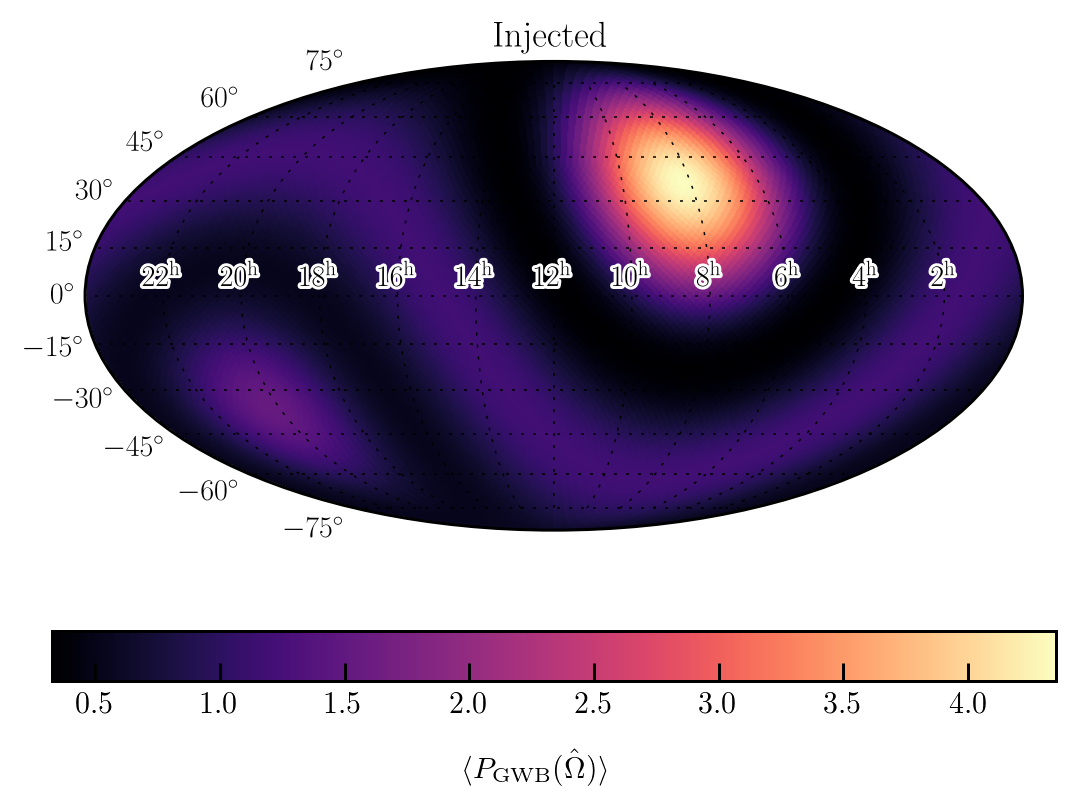

In [110]:
map_inj = bu.makeSkyMap(clm_inj[1:],lmax=4,nside=32,cmap=newcmaps.magma)
plt.title('Injected')
#plt.savefig('nanoAnisTests_pointInj.png',bbox_inches='tight',dpi=400)

## Spherical harmonic analysis: produce posterior averaged skymap

In [120]:
dirnames = sorted(glob.glob('chains_iptamdc_mockanishotspot_dataset*'))

In [121]:
dirnames

['chains_iptamdc_mockanishotspot_dataset0',
 'chains_iptamdc_mockanishotspot_dataset1',
 'chains_iptamdc_mockanishotspot_dataset2',
 'chains_iptamdc_mockanishotspot_dataset3',
 'chains_iptamdc_mockanishotspot_dataset4']

In [122]:
clm_chain = []
for ii,name in enumerate(dirnames):
    try:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    except:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [123]:
LMAX = 4

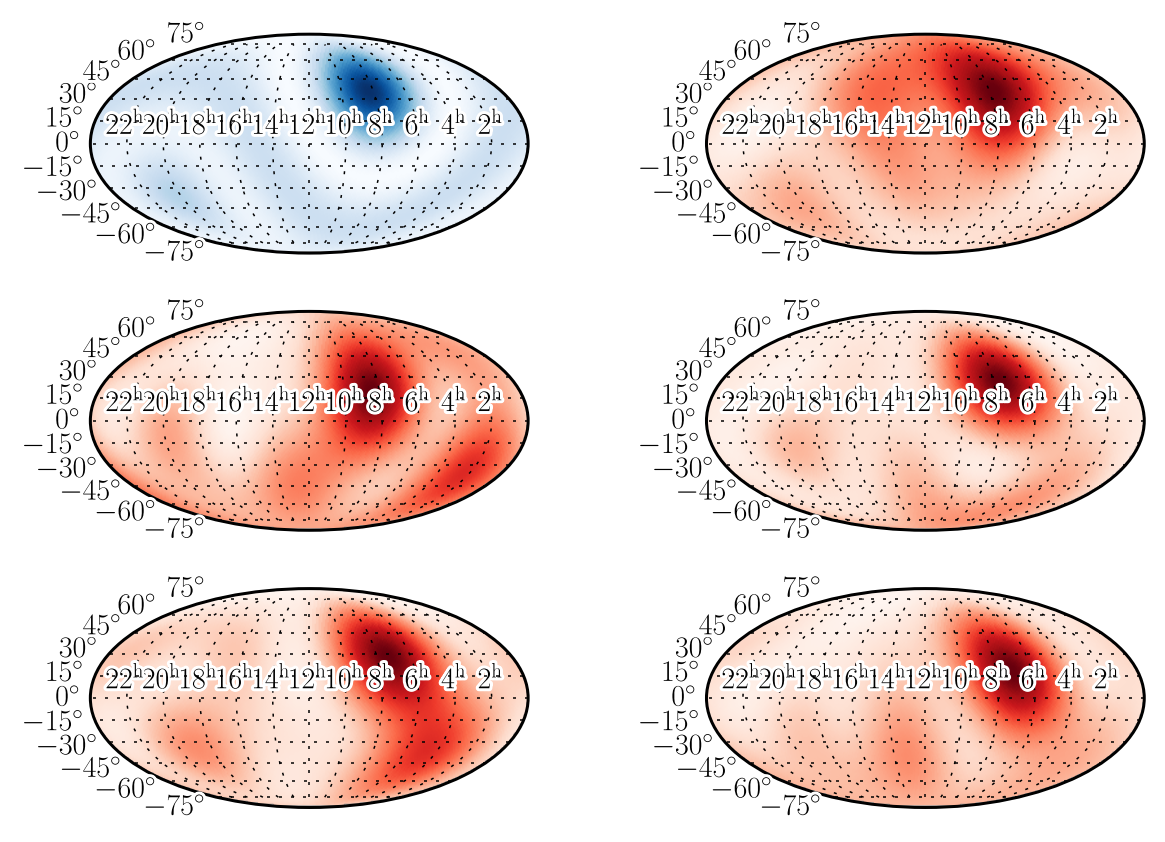

In [124]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

In [104]:
dipole_chain = np.loadtxt('./chains_iptamdc_mockanisdipole_dataset0/pta_gwbloguniform_Lmax1_noPhysPrior_gamVary_redFix_nmodes20/chain_1.txt')

In [105]:
dipole_chain.shape

(15400, 9)

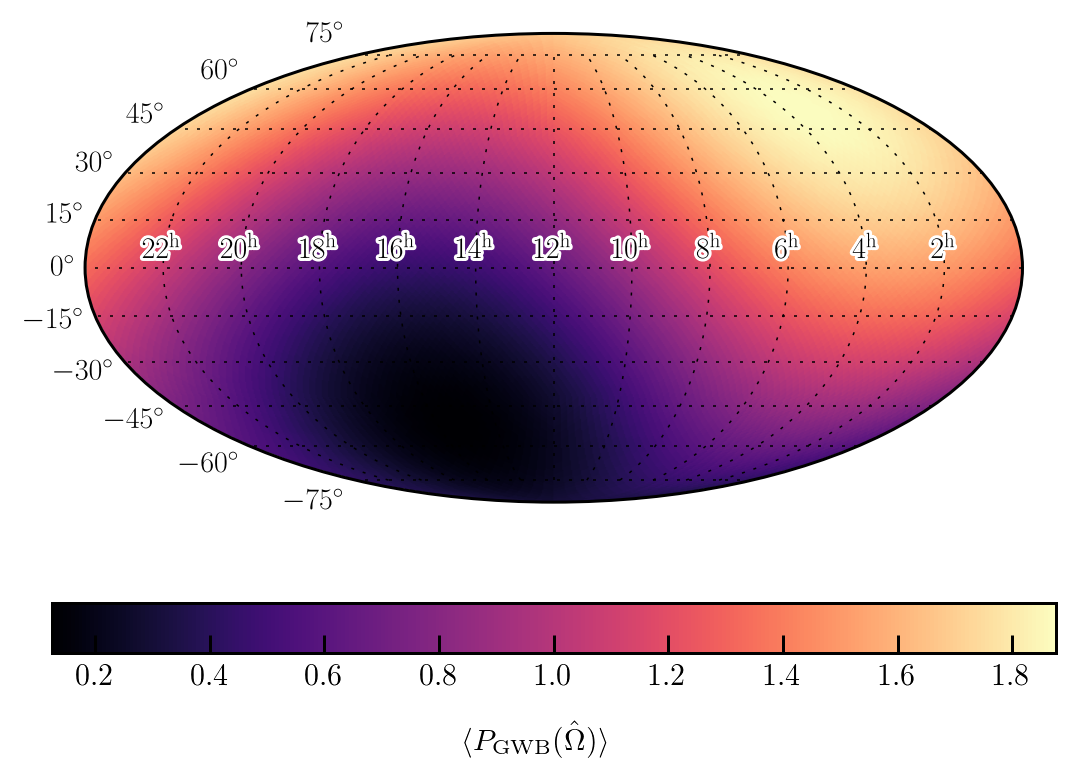

In [107]:
bu.makeSkyMap(dipole_chain[5000:,-4-(1+1)**2+1:-4],
              lmax=1, nside=32, 
              cmap=newcmaps.magma)

In [130]:
dirnames = sorted(glob.glob('chains_iptamdc_nanotype_mockanishotspot*'))

In [131]:
dirnames

['chains_iptamdc_nanotype_mockanishotspot',
 'chains_iptamdc_nanotype_mockanishotspot_dataset1',
 'chains_iptamdc_nanotype_mockanishotspot_dataset2',
 'chains_iptamdc_nanotype_mockanishotspot_dataset3',
 'chains_iptamdc_nanotype_mockanishotspot_dataset4']

In [139]:
nano_chain = []
for ii,name in enumerate(dirnames):
    #try:
    #    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    #except:
    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [140]:
LMAX = 4

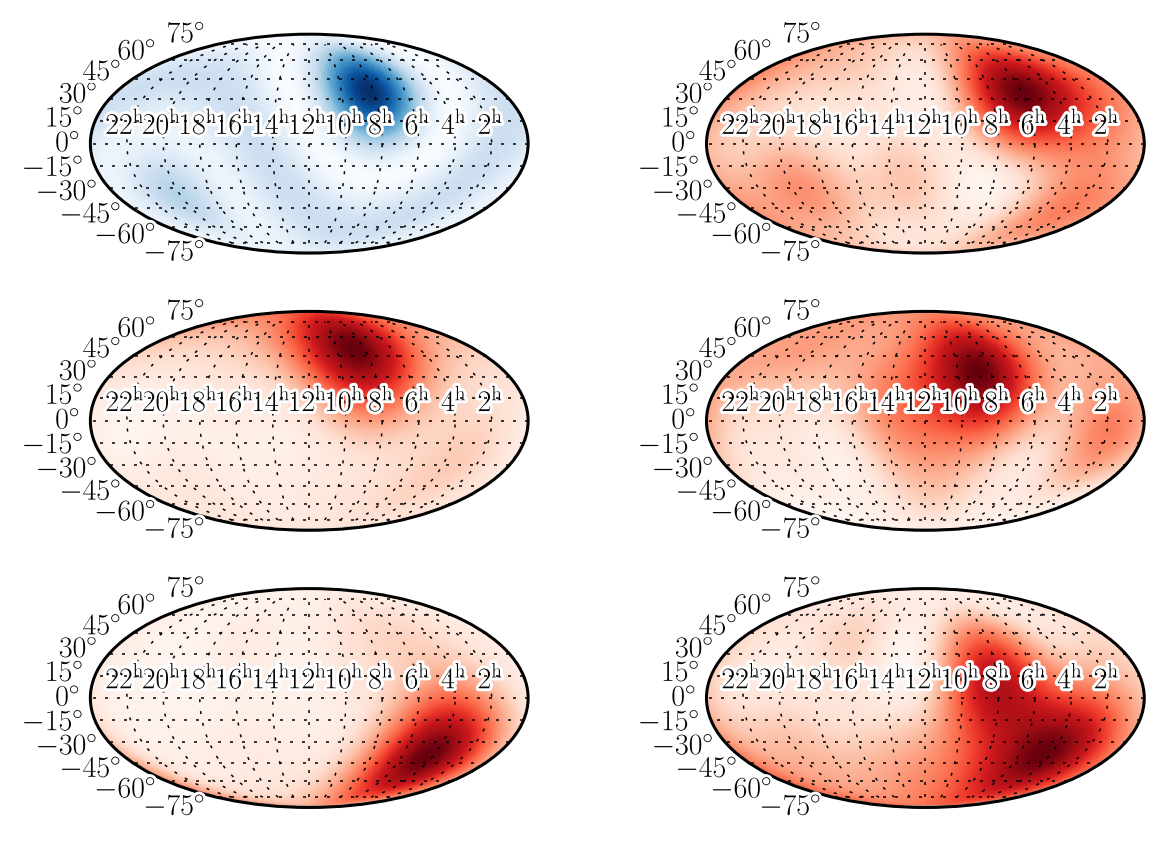

In [141]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

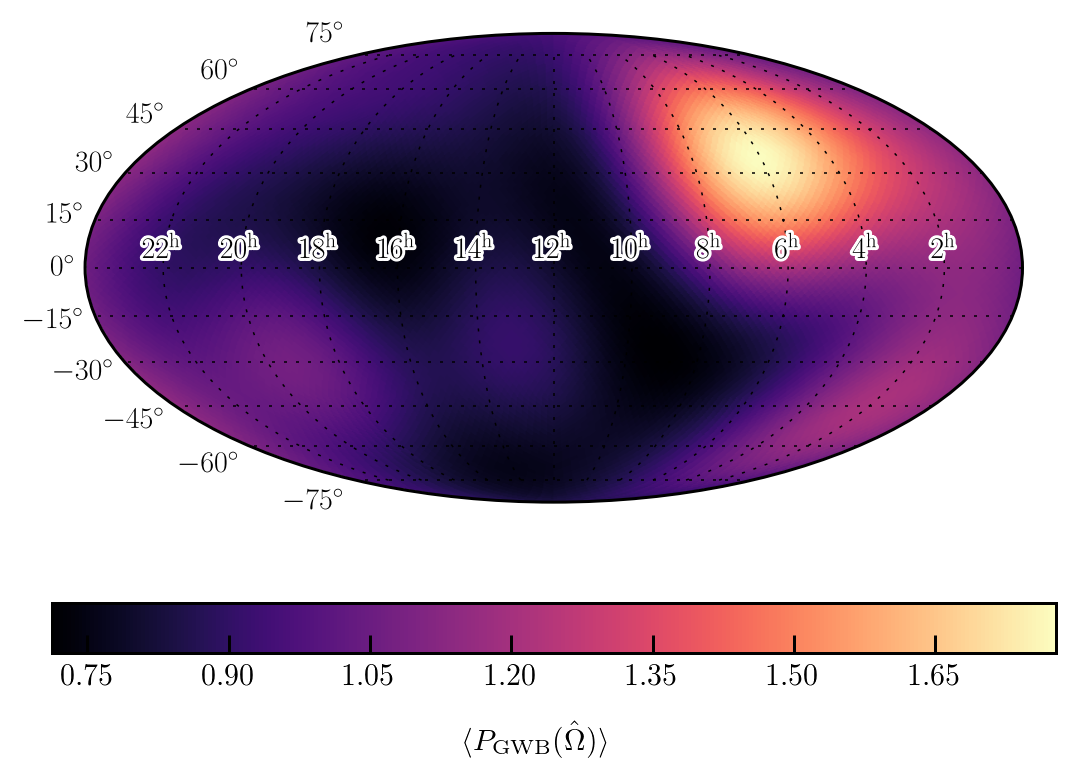

In [103]:
bu.makeSkyMap(nano_chain[1000:,-4-(4+1)**2+1:-4],
              lmax=4, nside=32, 
              cmap=newcmaps.magma)

In [142]:
nano_priorchain = np.loadtxt('./chains_nano9yr_anisConstLike/pta_constLike_gwbloguniform_Lmax4_gamVary_reduniformpowerlaw_nmodes15/chain_1.txt')

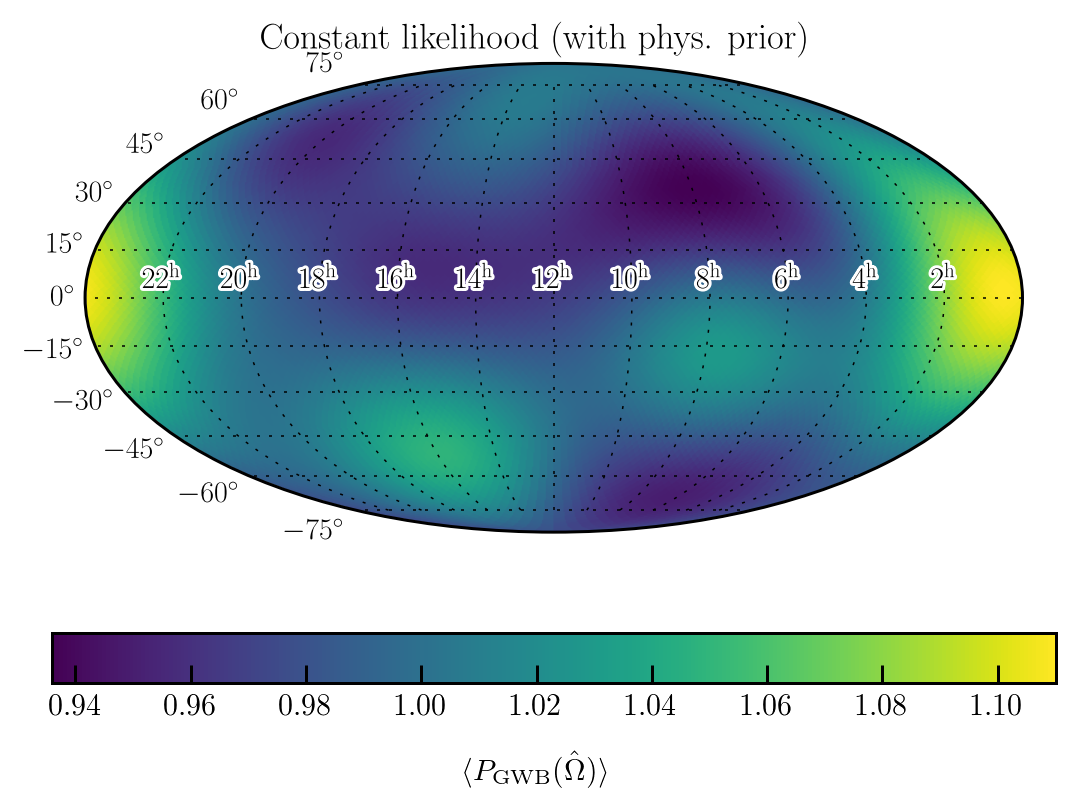

In [146]:
bu.makeSkyMap(nano_priorchain[1000:,-4-(4+1)**2+1:-4],
              lmax=4, nside=32, 
              cmap=newcmaps.viridis)
plt.title('Constant likelihood (with phys. prior)')
#plt.savefig('nano9yr_lmax4physprior_constLike.pdf',bbox_inches='tight',dpi=400)

## Point-source anisotropy: produce posterior averaged skymap

In [5]:
pointSrc_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_pointSrc_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

Sigma is 68.754935 arcmin (0.020000 rad) 
-> fwhm is 161.905500 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


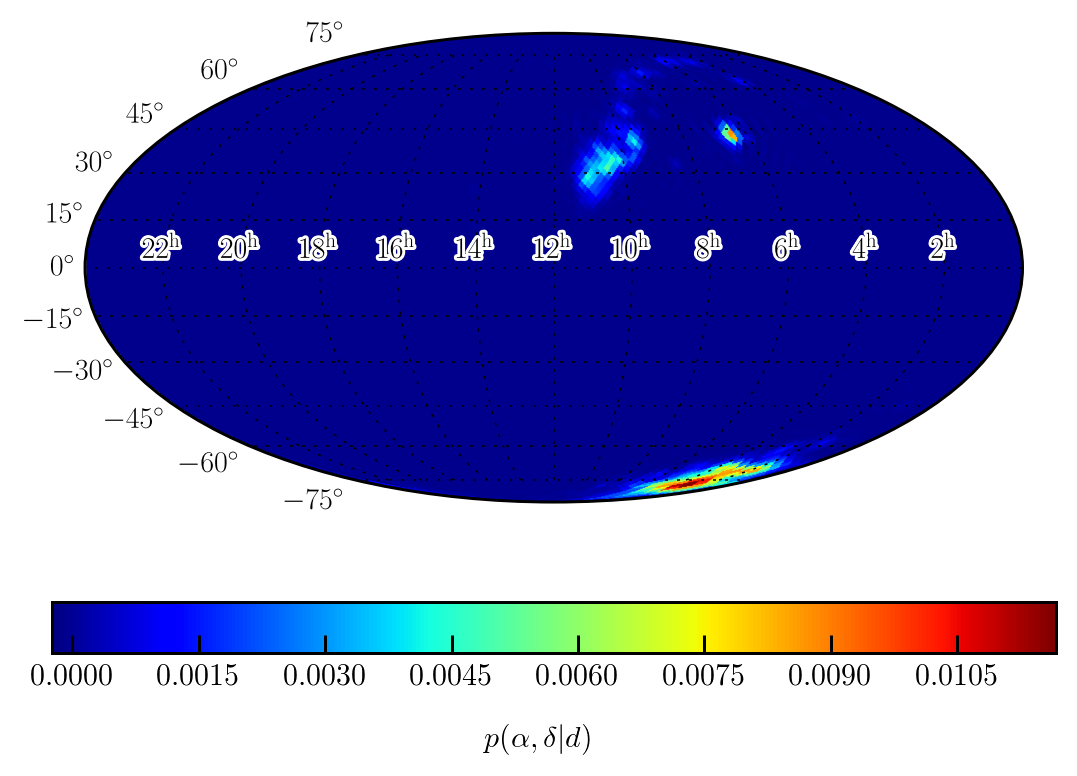

In [11]:
#map_point = bu.plotSkyMap(pointSrc_chain[:,74], np.pi/2. - np.arccos(pointSrc_chain[:,75]), nside=64, cmap='jet', outfile='skymap.pdf')
map_point = bu.plotSkyMap(pointSrc_chain[:,74] + np.pi, np.pi/2. - (np.pi - np.arccos(pointSrc_chain[:,75])), nside=32, cmap='jet', outfile='skymap.pdf')